In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## Tools to load in the annotations

I will want to load in annotations from both sets of labellers

In [70]:
mapper = {'road traffic': 'Mix traffic',
          'electrical disturbance': 'electrical',
         'vehicle': 'Mix traffic',
         'breaking vehicle': 'Braking',
         'Train doors (beeping)': 'beep'}

In [71]:
sample_rate = 24000 
file_len_in_seconds = 60

def read_labels(fname):

    df = pd.read_csv(fname)
    df = df.ix[1::2]  # we need to take every other row
    
    # cool, we read in the labels as a pandas df. 
    # Now we want to convert this to our own format, where we have a dictionary of arrays, one per label...
    labels = {}
    
    for labelname in df['Label'].unique():

        if labelname in mapper:
            labelname = mapper[labelname]

        these_labs = df.ix[df['Label'] == labelname]
        
        label_array = np.zeros(sample_rate * file_len_in_seconds)
        
        start_ends = np.array(
            these_labs[['LabelStartTime_Seconds', 'LabelEndTime_Seconds']])
        start_ends *= sample_rate
        start_ends  = start_ends.astype(int)

        for start, end in start_ends:
            label_array[start:end] = 1

        labels[labelname] = label_array

    return labels

## Number of labels given by each labeller

In [72]:
# Looking at the number of labels each labeller gave
from collections import defaultdict
num_labels = defaultdict(int)
for human in humans:
    fnames = os.listdir(base_path + human + '/')
    for fname in fnames:
        df = pd.read_csv(base_path + human + '/' + fname)
        num_labels[human] += df.shape[0]
        
print num_labels

defaultdict(<type 'int'>, {'Jiemin': 157, 'Verity': 364, 'Ali': 1641})


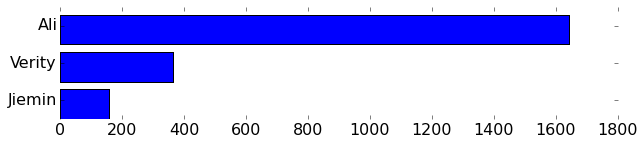

In [73]:
plt.figure(figsize=(10, 2))
plt.barh(range(3), num_labels.values())
plt.gca().set_yticks([0.5, 1.5, 2.5])
plt.gca().set_yticklabels(num_labels.keys(), fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=16)
plt.box('off')

## Loading in annotations as label numpy arrays

In [74]:
base_path = '/media/michael/Seagate/engage/engage_hackathon_data/data/multiple_humans_labelling_same_files/'
humans = ['Ali', 'Jiemin', 'Verity']
labels = {human: {} for human in humans}


for human in humans:
    fnames = os.listdir(base_path + human + '/')
    for fname in fnames:
        
        # generate key for this file
        filekey = fname.replace('_below12kHz.csv', '').replace('-sceneRect.csv', '')
        
        # load the file and add to the dictionary
        labels[human][filekey] = read_labels(base_path + human + '/' + fname)

In [75]:
all_labels = set()
for human in humans:
    for fname in labels[human].keys():
        all_labels.update(labels[human][fname].keys())
print all_labels

set(['siren', 'barking dog', 'unknown', 'Braking', 'anthropogenic unknown', 'Mix traffic', 'voices', 'beep', 'whistle', 'unknown sound', 'electrical', 'human voice', 'animal', 'lawnmower', 'airplane', 'invertebrate', 'bird', 'wind', 'machinery'])


## Comparing labels from the different labelers

In [76]:
classes = ['airplane', 'bird', 'Mix traffic', 'beep', 'electrical']
all_agreements = {cls:[] for cls in classes}

def get_labels(human, fname, cls):
    if cls not in labels[human][fname]:
        # if no labels, just give it an array of zeros
        return np.zeros(sample_rate * file_len_in_seconds)
    else:
        return labels[human][fname][cls]
    
results = pd.DataFrame(columns=['fname'] + classes)


# get the labels for this file, for this class, for all humans
for idx, fname in enumerate(labels['Ali'].keys()):

    fname_agreements = [fname]
    
    for cls in classes:
        labs = np.vstack([get_labels(human, fname, cls) for human in humans])
        agreements = labs.max(0) == labs.min(0)
        fname_agreements.append(agreements.mean())
       
    results.loc[idx] = fname_agreements

In [77]:
pd.set_option('precision',5)
results

,fname,airplane,bird,Mix traffic,beep,electrical
0,E105JP-13548_20131009_0717,0.0007,0.3240,1.0000,1.0000,0.9970
1,CR8-13548_20130918_1109,1.0000,0.7192,0.5452,1.0000,1.0000
2,SE23-13527_20130907_1651,0.0013,0.4325,1.0000,1.0000,1.0000
3,HA86RB-13527_20130730_0541,1.0000,0.6880,0.5603,1.0000,1.0000
4,SW154LA-3527_20130705_0909,1.0000,0.6475,0.0008,0.9888,1.0000
5,CR05EF-13527_20130921_1236,0.7847,0.6833,0.1207,1.0000,0.9970
6,CR05EF-13527_20130916_0823,0.0032,0.5602,1.0000,0.8827,0.9980
7,HA53AA-13548_20130727_0954,1.0000,0.9918,0.5017,1.0000,1.0000
8,W112NN-13548_20130709_0403,1.0000,0.4755,0.7288,1.0000,1.0000
9,W112NN-13548_20130713_0448,1.0000,0.6867,0.3445,1.0000,1.0000


In [78]:
for fname in ['E105JP-13548_20131009_0717', 'CR05EF-13527_20130921_1236']:

    print fname
    print '-' * 40 + '\n'
    for label in classes:
        for idx, human in enumerate(humans):

            if label in labels[human][fname]:
                frac = labels[human][fname][label].mean()
            else:
                frac = 0

            print "    Labeller %d labelled %02.2f%% as %s" % (idx, frac * 100, label)
        print ""

E105JP-13548_20131009_0717
----------------------------------------

    Labeller 0 labelled 0.00% as airplane
    Labeller 1 labelled 93.77% as airplane
    Labeller 2 labelled 63.28% as airplane

    Labeller 0 labelled 66.90% as bird
    Labeller 1 labelled 0.00% as bird
    Labeller 2 labelled 5.42% as bird

    Labeller 0 labelled 0.00% as Mix traffic
    Labeller 1 labelled 0.00% as Mix traffic
    Labeller 2 labelled 0.00% as Mix traffic

    Labeller 0 labelled 0.00% as beep
    Labeller 1 labelled 0.00% as beep
    Labeller 2 labelled 0.00% as beep

    Labeller 0 labelled 0.30% as electrical
    Labeller 1 labelled 0.00% as electrical
    Labeller 2 labelled 0.00% as electrical

CR05EF-13527_20130921_1236
----------------------------------------

    Labeller 0 labelled 0.00% as airplane
    Labeller 1 labelled 0.00% as airplane
    Labeller 2 labelled 21.53% as airplane

    Labeller 0 labelled 25.85% as bird
    Labeller 1 labelled 0.00% as bird
    Labeller 2 labelled 16.8

## Fraction of time over which all labellers agree on the label

In [79]:
means = []

for fname in labels['Ali'].keys():

    block = []

    for label in classes:
        
        this_lab_labels = []
        
        for idx, human in enumerate(humans):

            if label in labels[human][fname]:
                labs = labels[human][fname][label]
            else:
                labs = np.zeros(sample_rate * file_len_in_seconds)
            this_lab_labels.append(labs)
            
        block.append(np.vstack(this_lab_labels))

    block = np.dstack(block).transpose((0, 2, 1))

    agreements = block.min(0) == block.max(0)
    all_labels_agree = agreements.all(0)

    means.append(all_labels_agree.mean())
    

print np.mean(means)
            

0.167401184641


## Getting labelling discrepencies on individual files

In [96]:
classes = list(all_labels)
from IPython.display import display
from collections import OrderedDict

for fname in labels['Ali'].keys():

    print ""
    print fname
    print '-' * 40 + '\n'
    
    file_labels = OrderedDict({'Class': classes})
    
    
    for idx, human in enumerate(humans):
        
        fracs = []
        for label in classes:    
        
        

            if label in labels[human][fname]:
                fracs.append(labels[human][fname][label].mean() * 100)
            else:
                fracs.append(0)
            
            file_labels[human] = fracs
    df = pd.DataFrame(file_labels)

    display(df.replace(0, ' '))


E105JP-13548_20131009_0717
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,99.983
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



CR8-13548_20130918_1109
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,,,3.3
5,Mix traffic,,45.483,
6,voices,78.65,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



SE23-13527_20130907_1651
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,99.983
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



HA86RB-13527_20130730_0541
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,6.7833
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,43.967,
6,voices,,,
7,beep,,,
8,whistle,,6.05,
9,unknown sound,,,



SW154LA-3527_20130705_0909
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,2.2
3,Braking,,3.05,
4,anthropogenic unknown,,,
5,Mix traffic,,99.917,
6,voices,,,
7,beep,,1.1167,
8,whistle,,,
9,unknown sound,,,



CR05EF-13527_20130921_1236
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,1.0667
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,87.933,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



CR05EF-13527_20130916_0823
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,52.883
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,,
6,voices,,,
7,beep,,11.733,
8,whistle,,17.867,
9,unknown sound,,,



HA53AA-13548_20130727_0954
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,31.783
3,Braking,,,
4,anthropogenic unknown,,,8.3999
5,Mix traffic,,49.833,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



W112NN-13548_20130709_0403
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,27.117,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



W112NN-13548_20130713_0448
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,65.55,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



W112NN-13548_20130709_1234
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,,,0.61667
5,Mix traffic,,6.6667,
6,voices,15.233,,
7,beep,,,
8,whistle,,,
9,unknown sound,0.48333,,



HA86RB-13527_20130728_1101
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,99.933,
6,voices,1.7167,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



SE3-13548_20130911_0655
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,0.68333
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,99.75,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



WC2H8LG-3527_20130715_1400
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,5.9667,
1,barking dog,,,
2,unknown,,,
3,Braking,,,
4,anthropogenic unknown,17.15,,9.0667
5,Mix traffic,,99.801,
6,voices,99.683,,
7,beep,,2.6666,
8,whistle,,15.483,
9,unknown sound,,,



HA53AA-13548_20130729_0801
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,1.45
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,99.933,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



CR8-13548_20130921_0806
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,99.983
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,84.85,
6,voices,,,
7,beep,,,
8,whistle,,,
9,unknown sound,,,



HA86RB-13527_20130726_1319
----------------------------------------



,Class,Ali,Jiemin,Verity
0,siren,,,
1,barking dog,,,
2,unknown,,,11.55
3,Braking,,,
4,anthropogenic unknown,,,
5,Mix traffic,,85.733,
6,voices,2.95,,
7,beep,,,
8,whistle,,,
9,unknown sound,16.317,,
